# Car Sales Analytics

We investigate Car Sales data from [1] and apply Machine Learning via Spark MLlib to draw key insights.

A great deal of inspiration was drawn from Practical 8. In particular, the 'Bank Deposit Prediction' notebook.

**<u>Author:</u> Adrian Rahul Kamal Rajkamal**

**<u>Student Number:</u> 45811935**

**INFS3208**

**Semester 2, 2022**

[1] C. Union, "Car Features and MSRP," 2016. [Online]. Available: https://www.kaggle.com/datasets/CooperUnion/cardataset. [Accessed 30 September 2022].

## Imports and Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, lit, desc
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
spark = SparkSession.builder.appName('car-sales').getOrCreate()
df = spark.read.csv('hdfs://namenode/data.csv', header=True, inferSchema=True)

## Exploratory Data Analysis (EDA) and Data Cleaning

In [3]:
df.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



In [4]:
df.toPandas()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


### Initial Insights

We observe that the 'Market Category' column/feature can take on multiple values for each car. To simplify pre-processing, we begin by excluding this column from our analytics.

It is unclear how exactly 'Popularity' is measured. So, we exclude this column.

In [5]:
excluded_feature_names = ["Market Category", "Popularity"]
reduced_feature_names = [c for c in df.columns if c not in excluded_feature_names]
df = df.select(reduced_feature_names)
df.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



We now consider summary statistics of this reduced feature space:

In [6]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11914,None,None,Acura,Volvo
Model,11914,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11914,2010.384337753903,7.5797398875957995,1990,2017
Engine Fuel Type,11911,None,None,diesel,regular unleaded
Engine HP,11845,249.38607007176023,109.19187025917194,55,1001
Engine Cylinders,11884,5.628828677213059,1.78055934824622,0,16
Transmission Type,11914,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11914,None,None,all wheel drive,rear wheel drive
Number of Doors,11908,3.4360933825999327,0.8813153865835529,2,4


### Further Cleaning & Insights

We observe "UNKNOWN" values for Transmission Type. We remove these, along with any other NULL values/missing data.

In [7]:
# Convert "UNKNOWN" values into NULL and then drop all NULL values
df = df.withColumn("Transmission Type", when(col("Transmission Type") != "UNKNOWN", col("Transmission Type"))
                   .otherwise(lit(None)))
df = df.na.drop()
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11793,None,None,Acura,Volvo
Model,11793,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11793,2010.386246078182,7.574156505524067,1990,2017
Engine Fuel Type,11793,None,None,diesel,regular unleaded
Engine HP,11793,249.63724243195117,109.21256570745885,55,1001
Engine Cylinders,11793,5.649029085050453,1.752356704051638,0,16
Transmission Type,11793,None,None,AUTOMATED_MANUAL,MANUAL
Driven_Wheels,11793,None,None,all wheel drive,rear wheel drive
Number of Doors,11793,3.4346646315610956,0.8818379402519843,2,4


### Individual Feature Analysis

We consider the properties of individual columns/features now.

For discrete features, we consider their proportions and counts (i.e. to identify class imbalances, etc.).

For continuous features, we consider measures of spread (i.e. to identify outliers, etc.)

In [8]:
df.columns

['Make',
 'Model',
 'Year',
 'Engine Fuel Type',
 'Engine HP',
 'Engine Cylinders',
 'Transmission Type',
 'Driven_Wheels',
 'Number of Doors',
 'Vehicle Size',
 'Vehicle Style',
 'highway MPG',
 'city mpg',
 'MSRP']

In [9]:
# Ignore "Model" due to repetitive values and dependency on "Make"
discrete_features = ["Make", "Year", "Engine Fuel Type", "Engine Cylinders", "Transmission Type", "Driven_Wheels", "Number of Doors", "Vehicle Size", "Vehicle Style"]
continuous_features = ["Engine HP", "highway MPG", "city mpg", "MSRP"]

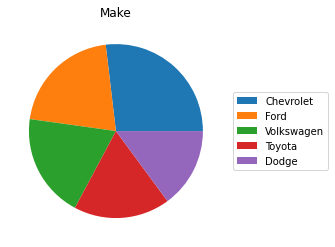

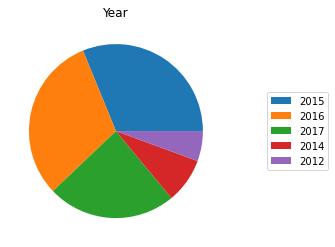

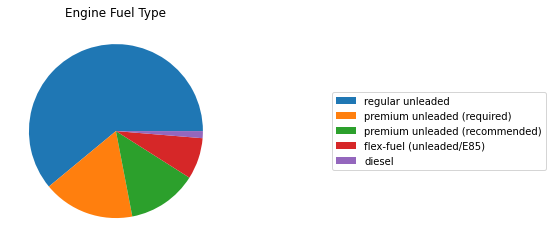

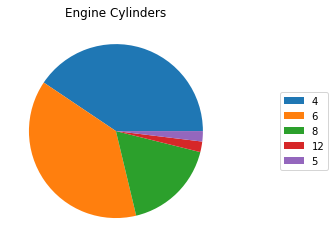

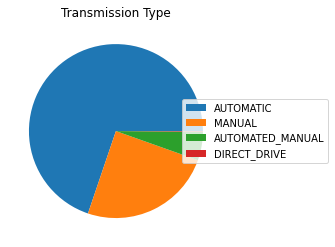

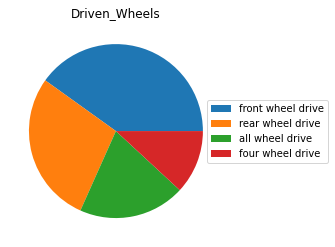

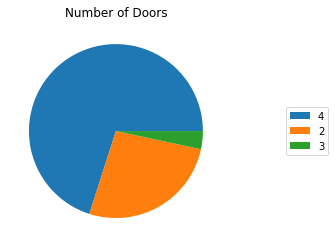

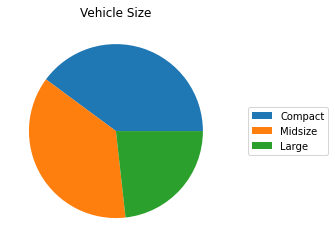

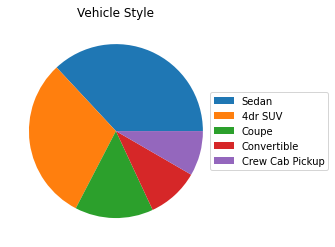

In [10]:
for disc_feat in discrete_features:
    plt.figure()
    # for simplicity, only consider top 5 categories per feature
    curr_feat = df.groupby(disc_feat).count().sort(desc("count")).limit(5).toPandas()
    plt.pie(curr_feat["count"])
    plt.title(disc_feat)
    if_fuel = 1.5 + (disc_feat == "Engine Fuel Type")  # Boolean acts as indicator variable
    # Move legend outside of plot for readability (bit further outside if Engine Fuel Type)
    plt.legend(labels=curr_feat[disc_feat], loc='right', bbox_to_anchor=(if_fuel, 0.5))
    plt.show()

As we can see, all discrete features have imbalanced classes. However, as we are considering the most popular classes in each feature, the smaller classes are not as small as they may appear, when considering all classes.

As a result, no feature balancing will be conducted to ensure model generalisability.

Now, we consider continuous features.

In [11]:
continuous_features = ["Engine HP", "highway MPG", "city mpg", "MSRP"]

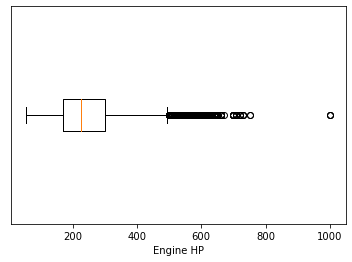

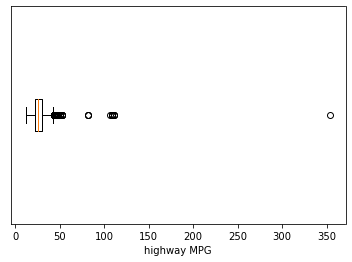

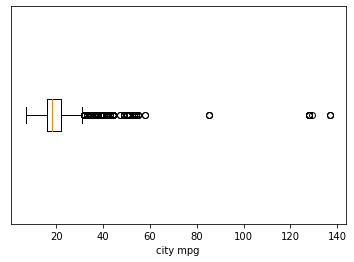

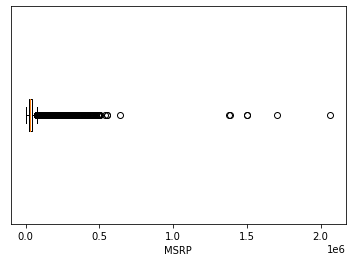

In [12]:
for con_feat in continuous_features:
    plt.boxplot(df.select(con_feat).toPandas(), vert=False)
    plt.xlabel(con_feat)
    plt.yticks([])
    plt.show()

We may observe that several outliers exist across all continuous features. These are likely due to high-performance vehicles, as these are naturally quite expensive, powerful, and fuel-inefficient. But, we investigate further to ensure this is indeed the case.

In any case, we remove the outliers to ensure our models have a strong fit to the data.

In [13]:
df.sort(desc("Engine HP")).limit(10).toPandas()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,MSRP
0,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,1705769
1,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,1500000
2,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,2065902
3,Lamborghini,Aventador,2016,premium unleaded (required),750,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Coupe,18,11,490700
4,Lamborghini,Aventador,2016,premium unleaded (required),750,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Convertible,18,11,535500
5,Ferrari,F12 Berlinetta,2014,premium unleaded (required),731,12,AUTOMATED_MANUAL,rear wheel drive,2,Midsize,Coupe,16,11,315888
6,Ferrari,F12 Berlinetta,2015,premium unleaded (required),731,12,AUTOMATED_MANUAL,rear wheel drive,2,Midsize,Coupe,16,11,319995
7,Ferrari,F12 Berlinetta,2013,premium unleaded (required),731,12,AUTOMATED_MANUAL,rear wheel drive,2,Midsize,Coupe,16,11,315888
8,Lamborghini,Aventador,2015,premium unleaded (required),720,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Convertible,16,10,548800
9,Lamborghini,Aventador,2015,premium unleaded (required),720,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Coupe,18,11,497650


In [14]:
df.sort(desc("highway MPG")).limit(10).toPandas()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,MSRP
0,Audi,A6,2017,premium unleaded (recommended),252,4,AUTOMATED_MANUAL,front wheel drive,4,Midsize,Sedan,354,24,51600
1,BMW,i3,2016,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,111,137,42400
2,BMW,i3,2015,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,111,137,42400
3,BMW,i3,2017,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,111,137,42400
4,Chevrolet,Spark EV,2014,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,26685
5,Chevrolet,Spark EV,2015,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25560
6,Chevrolet,Spark EV,2014,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,27010
7,Chevrolet,Spark EV,2016,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25510
8,Chevrolet,Spark EV,2016,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25120
9,Chevrolet,Spark EV,2015,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25170


In [15]:
df.sort(desc("city mpg")).limit(10).toPandas()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,i3,2017,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,111,137,42400
1,BMW,i3,2016,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,111,137,42400
2,BMW,i3,2015,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,111,137,42400
3,BMW,i3,2017,electric,170,0,DIRECT_DRIVE,rear wheel drive,4,Compact,4dr Hatchback,106,129,43600
4,Chevrolet,Spark EV,2014,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,26685
5,Chevrolet,Spark EV,2015,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25560
6,Chevrolet,Spark EV,2014,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,27010
7,Chevrolet,Spark EV,2016,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25510
8,Chevrolet,Spark EV,2016,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25120
9,Chevrolet,Spark EV,2015,electric,140,0,DIRECT_DRIVE,front wheel drive,4,Compact,4dr Hatchback,109,128,25170


In [16]:
df.sort(desc("MSRP")).limit(10).toPandas()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,MSRP
0,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,2065902
1,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,1705769
2,Lamborghini,Reventon,2008,premium unleaded (required),650,12,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,9,1500000
3,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001,16,AUTOMATED_MANUAL,all wheel drive,2,Compact,Coupe,14,8,1500000
4,Maybach,Landaulet,2012,premium unleaded (required),620,12,AUTOMATIC,rear wheel drive,4,Large,Convertible,16,10,1382750
5,Maybach,Landaulet,2011,premium unleaded (required),620,12,AUTOMATIC,rear wheel drive,4,Large,Convertible,16,10,1380000
6,Ferrari,Enzo,2003,premium unleaded (required),660,12,AUTOMATED_MANUAL,rear wheel drive,2,Compact,Coupe,12,7,643330
7,Lamborghini,Aventador,2014,premium unleaded (required),720,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Convertible,16,10,548800
8,Lamborghini,Aventador,2015,premium unleaded (required),720,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Convertible,16,10,548800
9,Lamborghini,Aventador,2016,premium unleaded (required),750,12,AUTOMATED_MANUAL,all wheel drive,2,Midsize,Convertible,18,11,535500


Upon further inspection, it is clear that the Bugatti cars are outliers purely due to being high-end cars. These will be removed from the dataset due to their high engine HP values.

All cars with an MSRP of >= 1 000 000 will be removed as outliers as well.

The BMW i3 cars are electric vehichles, so these will NOT be removed as this MPG information may be useful for the model to capture for the sake of generalisability.

The Audi A6 model has quite a suspiciously high highway MPG value, so this will be removed from the dataset.

In [17]:
# Remove Bugattis
df = df.filter(df['Make'] != "Bugatti")

# Remove million-dollar vehicles
df = df.filter(df['MSRP'] < 1000000)

# Remove Audi A6 with suspiciously high highway MPG
df = df.filter(df['highway MPG'] < 354)

Let us inspect the spread once more after this cleaning.

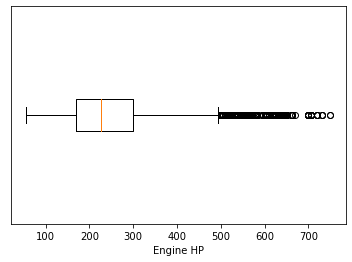

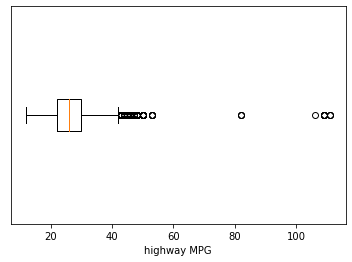

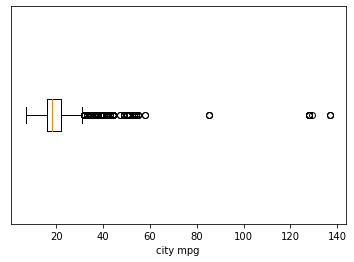

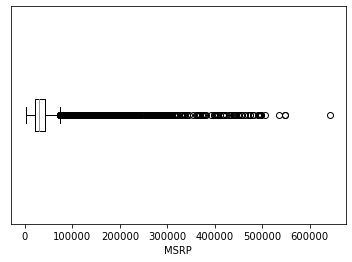

In [18]:
for con_feat in continuous_features:
    plt.boxplot(df.select(con_feat).toPandas(), vert=False)
    plt.xlabel(con_feat)
    plt.yticks([])
    plt.show()

Indeed, the remaining outliers seem reasonable to remain in the dataset.

### Correlations Between Features

We use code from Practical 8 to produce a Draftsman's display of all numerical features, in order to identify correlations.

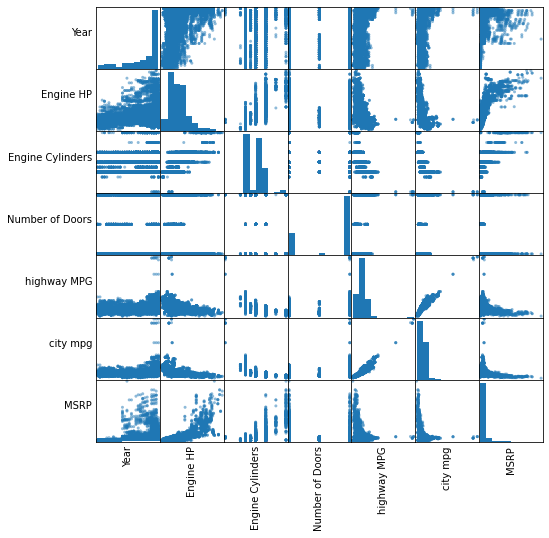

In [19]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
axs = pd.plotting.scatter_matrix(df.select(numeric_features).toPandas(), figsize=(8, 8));
n = len(numeric_features)

# Rotate axis labels and remove axis ticks
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n - 1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

We observe weak correlations at best between some features (e.g. engine HP vs MSRP), and a strong correlation between highway and city mpg, as one would expect.

Since both highway and city mpg measure fuel efficiency, and the majority of people drive in the city, we will remove the highway MPG feature.

In [20]:
df = df.select([c for c in df.columns if c != "highway MPG"])
df.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



## Machine Learning Algorithms + Visualisation/Testing

### Task 1: Regression Model for MSRP

We formulate a (linear) regression model for MSRP, based on all other features in the (cleaned) Dataframe. This model could help second-hand car buyers consider if a particular car of interest is well-priced, given the features of said car.

In [21]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string']
continuous_features = [t[0] for t in df.dtypes if t[1] == 'int' and t[0] != 'MSRP']
stages = []

# Encode categorical features to be used for regression. Need to convert features to indexed features first. Then one-hot encode
# the indexed features. BELOW IS INSPIRED BY PRACTICAL 8
for cat_feat in categorical_features:
    str_ind = StringIndexer(inputCol = cat_feat, outputCol = cat_feat + 'Index')
    one_hot = OneHotEncoder(inputCols=[str_ind.getOutputCol()], outputCols=[cat_feat + "classVec"])
    stages += [str_ind, one_hot]

# Combine features
pre_processed_inputs = [c + "classVec" for c in categorical_features] + continuous_features
features = VectorAssembler(inputCols = pre_processed_inputs, outputCol = "features")

stages += [features]

In [22]:
# Set up pipeline & train/test split
pipeline = Pipeline(stages = stages)
pipeline_model = pipeline.fit(df)

# Get rid of all individual encodings (only need vector-assembled features)
df_regression = pipeline_model.transform(df).select(['features'] + df.columns)
training_data, testing_data = df_regression.randomSplit([0.7, 0.3], seed = 10)

In [23]:
# Train model
lin_reg = LinearRegression(featuresCol='features', labelCol='MSRP')
lin_reg_model = lin_reg.fit(training_data)

In [24]:
# Test model
test_pred = lin_reg_model.transform(testing_data)

In [25]:
# Convert true MSRP values and predictions from test_pred data frame to arrays of true MSRP values and predictions
MSRP_data = [float(row['MSRP']) for row in test_pred.select('MSRP').collect()]
pred_data = [float(row['prediction']) for row in test_pred.select('prediction').collect()]

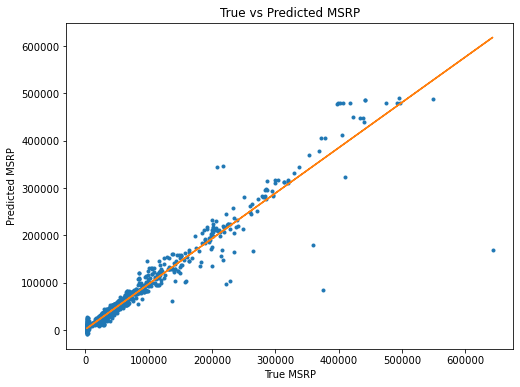

In [26]:
# Calculate Test R^2 value
eval = RegressionEvaluator(labelCol = 'MSRP')
r2 =eval.evaluate(test_pred, {eval.metricName:'r2'})

# Fit and plot line of best fit between true and predicted MSRP (Ideally, line should be approximately y=x, i.e. m approx 1 and
# c approx 0)
m, c = np.polyfit(MSRP_data, pred_data, 1)
plt.figure(figsize=(8, 6))
plt.plot(MSRP_data, pred_data, '.')
plt.plot(MSRP_data, m * np.array(MSRP_data) + c)
plt.xlabel('True MSRP')
plt.ylabel('Predicted MSRP')
plt.title('True vs Predicted MSRP')
plt.show()

In [27]:
# Evaluation Metrics
print("Model R^2 value:", r2)
print("Line of Best Fit Gradient:", m)
print("Line of Best Fit y-Intercept:", c)

Model R^2 value: 0.9388701046649763
Line of Best Fit Gradient: 0.9586801308301404
Line of Best Fit y-Intercept: 1620.5711732299521


Hence, we have developed a highly-accurate regression model for predicting MSRP. One may note a very large y-intercept value in our line of best fit. This is likely due to remaining outliers in the predictions that can be seen in the above plot.

One possible explanation for such outliers is if a car is quite famous. For example an older car with a 'cult status'. Such a car may not necessarily have the conventional qualities of an expensive car, but may simply be expensive due to its antiquity and history. This may have confused the regression model, when compared to say, older cars that are simply cheap and unpopular.

Perhaps this is what the 'Popularity' feature referred to in the original dataset.

### Task 2: Classification Model for Make

We now formulate a Random Forest classification model for Make, based on all other features in the (cleaned) Dataframe. This model could help buyers consider which brands best satisfy their requirements in a car, thereby narrowing down their decision process.

In [28]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] != 'Make']
continuous_features = [t[0] for t in df.dtypes if t[1] == 'int']
stages = []

# Encode categorical features to be used for regression. Need to convert features to indexed features first. Then one-hot encode
# the indexed features. BELOW IS INSPIRED BY PRACTICAL 8
for cat_feat in categorical_features:
    str_ind = StringIndexer(inputCol = cat_feat, outputCol = cat_feat + 'Index')
    one_hot = OneHotEncoder(inputCols=[str_ind.getOutputCol()], outputCols=[cat_feat + "classVec"])
    stages += [str_ind, one_hot]
    
# Encode class labels
make_label_stringIdx = StringIndexer(inputCol = 'Make', outputCol = 'label')
stages += [make_label_stringIdx]

# Combine features
pre_processed_inputs = [c + "classVec" for c in categorical_features] + continuous_features
features = VectorAssembler(inputCols = pre_processed_inputs, outputCol = "features")

stages += [features]

In [29]:
# Set up pipeline & train/test split
pipeline = Pipeline(stages = stages)
pipeline_model = pipeline.fit(df)

# Get rid of all individual encodings (only need vector-assembled features)
df_randForest = pipeline_model.transform(df).select(['label', 'features'] + df.columns)
training_data, testing_data = df_randForest.randomSplit([0.7, 0.3], seed = 10)

In [30]:
# Train model
rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(training_data)

In [31]:
# Test model
test_pred = rf_model.transform(testing_data)

In [32]:
# Calculate and plot predictive accuracies of each class (i.e. Make) in a bar graph

# Get unique set of car makes and their corresponding counts
make_counts = {row['Make']: row['count'] for row in df.groupby("Make").count().collect()}

# Count correct predictions for each make
pred_counts = {make: 0 for make in make_counts.keys()}
for row in test_pred.collect():
    if row["label"] == row["prediction"]:
        pred_counts[row["Make"]] += 1

preds_props = {make: pred_counts[make] / make_counts[make] for make in make_counts}

<BarContainer object of 46 artists>

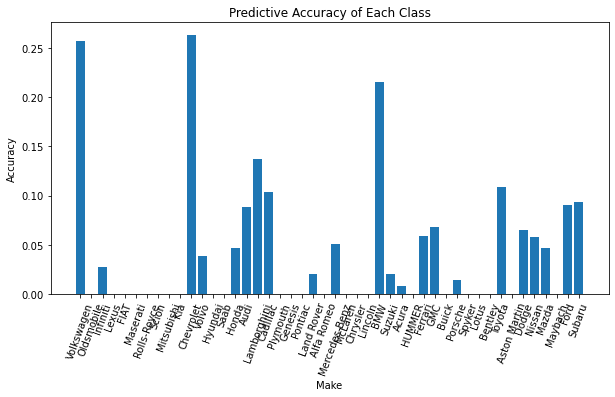

In [33]:
# Plot predictive accuracies
plt.figure(figsize=(10, 5))
plt.xticks(rotation=70)
plt.xlabel('Make')
plt.ylabel('Accuracy')
plt.title('Predictive Accuracy of Each Class')
plt.bar(preds_props.keys(), preds_props.values())

In [34]:
# Evaluate train and test and plot
eval = MulticlassClassificationEvaluator(labelCol='label')
print("Overall Test Accuracy:", eval.evaluate(test_pred,{eval.metricName:'accuracy'}))
print("True Positive Rate (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedTruePositiveRate'}))
print("False Positive Rate (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedFalsePositiveRate'}))
print("Precision (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedPrecision'}))
print("Recall (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedRecall'}))

Overall Test Accuracy: 0.2917488031540411
True Positive Rate (Weighted by Class Imbalances): 0.29174880315404106
False Positive Rate (Weighted by Class Imbalances): 0.06293389300819675
Precision (Weighted by Class Imbalances): 0.5889361781853312
Recall (Weighted by Class Imbalances): 0.29174880315404106


Indeed, one may observe that this classifer performed quite poorly, with respect to the above metrics (with the exceptions of weighted precision and false positive rate). This is likely due to two reasons:

1) Heavily Imbalanced Classes

2) Competition Between Brands

As observed during EDA, the number of cars of a particular make varies quite greatly. While one potential improvement could have been to perform further data cleaning, by removing data corresponding to rarer car makes, this would have likely made little difference. As observed in the EDA, all makes (including those more common) were highly imbalanced, along with **all** discrete features in the dataset.

Furthermore, even if this class imbalancing problem could be somehow resolved, car makes are, first and foremost, businesses. As a result, the specifications of different cars are (no pun intended) driven by competition with other car makes.

This in turn, leads to many cars being quite similar between car makes, leading to very similar feature values, leading to misclassifications, as a byproduct of a lack of uniqueness.

If further data on say, car design, could have been acquired, this may have improved the classifier, as design can often be a defining quality of a car make.

Regarding the unusually high weighted precision and unusually low weighted false positive rate, these are both likely just a byproduct of classes which were *never* predicted correctly. As weighted precision/false positive rate is weighted by class proportions, and precision is just the proportion of true positives to all positive predictions, these weightings attempt to mitigate the effects of successful classification for larger classes.

However, if a class is never predicted at all, then it was never predicted correctly or incorrectly. As this happened quite frequently (as per the bar graph above), this likely skewed the weighted precision/false positive rates results, leading to deceptively high-quality values.

### Task 3: Classification Model for Vehicle Style

We now formulate a multiple Logistic Regression classification model for Vehicle Style, based on all other features in the (cleaned) Dataframe. This model could help buyers consider what type of car (e.g. SUV, Sedan, etc.) would best satisfy their requirements in a car, thereby narrowing down their decision process.

In [35]:
categorical_features = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] != 'Vehicle Style']
continuous_features = [t[0] for t in df.dtypes if t[1] == 'int']
stages = []

# Encode categorical features to be used for regression. Need to convert features to indexed features first. Then one-hot encode
# the indexed features. BELOW IS INSPIRED BY PRACTICAL 8
for cat_feat in categorical_features:
    str_ind = StringIndexer(inputCol = cat_feat, outputCol = cat_feat + 'Index')
    one_hot = OneHotEncoder(inputCols=[str_ind.getOutputCol()], outputCols=[cat_feat + "classVec"])
    stages += [str_ind, one_hot]
    
# Encode class labels
style_label_stringIdx = StringIndexer(inputCol = 'Vehicle Style', outputCol = 'label')
stages += [style_label_stringIdx]

# Combine features
pre_processed_inputs = [c + "classVec" for c in categorical_features] + continuous_features
features = VectorAssembler(inputCols = pre_processed_inputs, outputCol = "features")

stages += [features]

In [36]:
# Set up pipeline & train/test split
pipeline = Pipeline(stages = stages)
pipeline_model = pipeline.fit(df)

# Get rid of all individual encodings (only need vector-assembled features)
df_multiLogReg = pipeline_model.transform(df).select(['label', 'features'] + df.columns)
training_data, testing_data = df_multiLogReg.randomSplit([0.7, 0.3], seed = 10)

In [37]:
# Train model
mutli_lr = LogisticRegression(featuresCol='features', labelCol='label')
mutli_lr_model = mutli_lr.fit(training_data)

In [38]:
# Test model
test_pred = mutli_lr_model.transform(testing_data)

In [39]:
# Calculate and plot predictive accuracies of each class (i.e. Vehicle Style) in a histogram

# Get unique set of car styles and their corresponding counts
style_counts = {row['Vehicle Style']: row['count'] for row in df.groupby('Vehicle Style').count().collect()}

# Count correct predictions for each vehicle style
pred_counts = {style: 0 for style in style_counts.keys()}
for row in test_pred.collect():
    if row["label"] == row["prediction"]:
        pred_counts[row["Vehicle Style"]] += 1

preds_props = {style: pred_counts[style] / style_counts[style] for style in style_counts}

<BarContainer object of 16 artists>

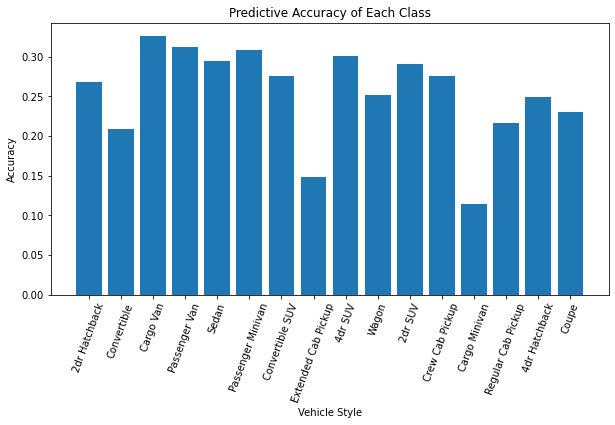

In [40]:
# Plot predictive accuracies
plt.figure(figsize=(10, 5))
plt.xticks(rotation=70)
plt.xlabel('Vehicle Style')
plt.ylabel('Accuracy')
plt.title('Predictive Accuracy of Each Class')
plt.bar(preds_props.keys(), preds_props.values())

In [41]:
# Evaluate train and test and plot
eval = MulticlassClassificationEvaluator(labelCol='label')
print("Overall Test Accuracy:", eval.evaluate(test_pred,{eval.metricName:'accuracy'}))
print("True Positive Rate (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedTruePositiveRate'}))
print("False Positive Rate (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedFalsePositiveRate'}))
print("Precision (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedPrecision'}))
print("Recall (Weighted by Class Imbalances):", eval.evaluate(test_pred,{eval.metricName:'weightedRecall'}))

Overall Test Accuracy: 0.8831315122500704
True Positive Rate (Weighted by Class Imbalances): 0.8831315122500702
False Positive Rate (Weighted by Class Imbalances): 0.012931024818889155
Precision (Weighted by Class Imbalances): 0.8845899046961037
Recall (Weighted by Class Imbalances): 0.8831315122500702


Thus, we have developed a reasonably accurate model for classfiying vehicle style.

As one would expect, classes which were smaller in size, had lower classification accuracy. Hence, one potential improvement to investigate is the effect of removing less popular vehicle styles from the dataset, on the classifier's performance.

Of course, this model still performed reasonably well, and by including less-common vehicle styles, this model generalises well to a larger consumer base. For example, instead of simply considering sedans, SUVs, hatchbacks, convertibles, etc., this model may aid a tradesperson in finding a suitable work vehicle, or perhaps a car rental company in finding suitable caravans, etc.